In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchgeometry as dgm

## Input Parameters


In [2]:
input_dir = './data'
src_name = 'img1.ppm'  # source image file
dst_name = 'img2.ppm'  # destinatipn image file
learning_rate = 1e-3
num_iterations = 1000  
log_interval = 200  # print log every 200 iterations
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Using ', device)

Using  cuda


In [3]:
def load_image(file_name):
    """Loads the image with OpenCV and converts to torch.Tensor                                      
    """
    assert os.path.isfile(file_name), "Invalid file {}".format(file_name)

    # load image with OpenCV                                                                         
    img = cv2.imread(file_name, cv2.IMREAD_COLOR)

    # convert image to torch tensor                                                                  
    tensor = dgm.utils.image_to_tensor(img).float() / 255.
    tensor = tensor.view(1, *tensor.shape)  # 1xCxHxW
    return tensor, img

### TODO: Pl add comments

In [4]:
class MyHomography(nn.Module):
    def __init__(self):
        super(MyHomography, self).__init__()
        self.homo = nn.Parameter(torch.Tensor(3, 3))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.eye_(self.homo)

    def forward(self):
        return torch.unsqueeze(self.homo, dim=0)  # 1x3x3  

### TODO: pl add comments

 $ Minnimize \sum |I_{ref} - \omega(I_{dst}, H_{ref}^{dst}))|$.

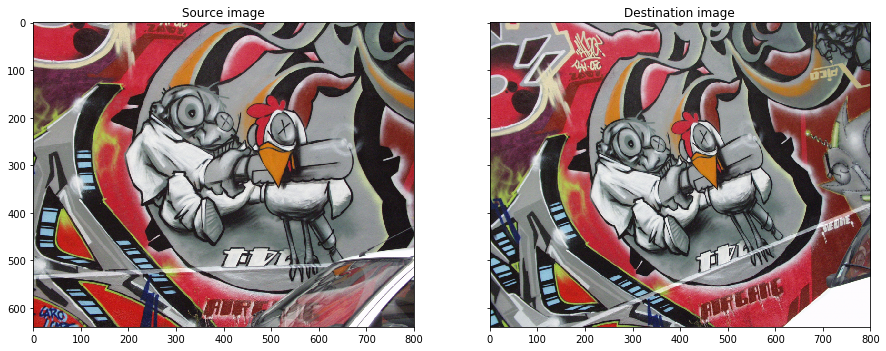

In [5]:
%matplotlib inline
img_src_t, img_src = load_image(os.path.join(input_dir, src_name))
img_dst_t, img_dst = load_image(os.path.join(input_dir, dst_name))
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)
ax1.imshow(img_src[:,:,::-1])
ax1.set_title('Source image')
ax2.imshow(img_dst[:,:,::-1])
ax2.set_title('Destination image')
plt.show()

### TODO: pl add comments

In [6]:
height, width = img_src_t.shape[-2:]
warper = dgm.HomographyWarper(height, width) #todo comment
dst_homo_src = MyHomography().to(device)
optimizer = optim.Adam(dst_homo_src.parameters(), lr=learning_rate)

### TODO: pl add comments

Train iteration: 0/1000	Loss: 0.275021


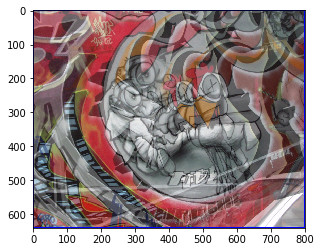

Train iteration: 200/1000	Loss: 0.198815


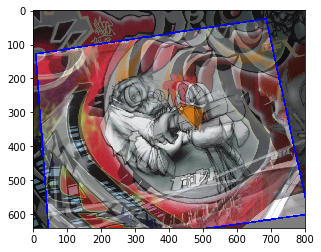

Train iteration: 400/1000	Loss: 0.015919


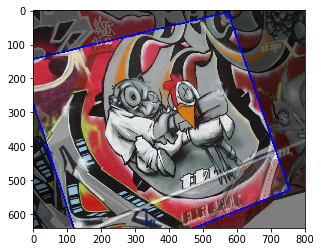

Train iteration: 600/1000	Loss: 0.015933


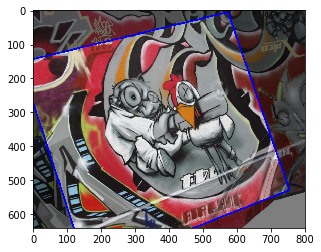

Train iteration: 800/1000	Loss: 0.0159485


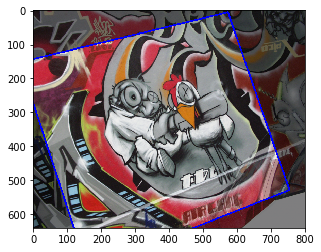

Train iteration: 999/1000	Loss: 0.0159272


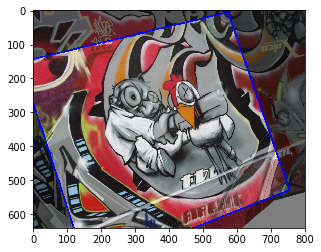

In [7]:
for iter_idx in range(num_iterations):
    # send data to device
    img_src_t, img_dst_t = img_src_t.to(device), img_dst_t.to(device)

    # warp the reference image to the destiny with current homography
    img_src_to_dst = warper(img_src_t, dst_homo_src())

    # compute the photometric loss
    loss = F.l1_loss(img_src_to_dst, img_dst_t, reduction='none')

    # propagate the error just for a fixed window
    w_size = 100  # window size
    h_2, w_2 = height // 2, width // 2
    loss = loss[..., h_2 - w_size:h_2 + w_size, w_2 - w_size:w_2 + w_size]
    loss = torch.mean(loss)

    # compute gradient and update optimizer parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if iter_idx % log_interval == 0 or iter_idx == num_iterations-1:
        print('Train iteration: {}/{}\tLoss: {:.6}'.format(
        iter_idx, num_iterations, loss.item()))
        # merge warped and target image for visualization
        img_src_to_dst = warper(img_src_t, dst_homo_src())
        img_vis = 255. * 0.5 * (img_src_to_dst + img_dst_t)
        img_vis_np = dgm.utils.tensor_to_image(img_vis)
        image_draw = dgm.utils.draw_rectangle(img_vis_np, dst_homo_src())
        plt.imshow(image_draw.astype('uint')[:,:,::-1])
        plt.show()  

### Compare H with groundtruth

In [8]:
depth_file_name = os.path.join(input_dir, 'H1to2p')
H_gt = torch.from_numpy(np.loadtxt(depth_file_name)).float()
H_est = dst_homo_src.homo.cpu().detach().numpy()
print('Estimated   H matrix:')
print( H_est) 
print('\nGroundTruth H matrix:')
print(H_gt.cpu().detach().numpy())

Estimated   H matrix:
[[ 1.0684841  -0.28878316  0.0728481 ]
 [ 0.35825172  0.91092825 -0.08299013]
 [-0.0768643   0.02848962  0.8815933 ]]

GroundTruth H matrix:
[[ 8.7976962e-01  3.1245437e-01 -3.9430588e+01]
 [-1.8389419e-01  9.3847197e-01  1.5315784e+02]
 [ 1.9641424e-04 -1.6015276e-05  1.0000000e+00]]
